In [1]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
with open("data.txt", "w") as f:
    for row in data.tolist():
        json.dump(row, f)
        f.write("\n")

In [2]:
%%writefile mr_GMixEmInitialize.py
from mrjob.job import MRJob

from numpy import mat, zeros, shape, random, array, zeros_like, dot, linalg
from random import sample
import json
from math import pi, sqrt, exp, pow


class MrGMixEmInit(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEmInit, self).__init__(*args, **kwargs)
        
        self.numMappers = 1     #number of mappers
        self.count = 0
        
                                                 
    def configure_options(self):
        super(MrGMixEmInit, self).configure_options()
        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, xjIn):
        #something simple to grab random starting point
        #collect the first 2k
        if self.count <= 2*self.options.k:
            self.count += 1
            yield (1,xjIn)        
        
    def reducer(self, key, xjIn):        
        #accumulate data points mapped to 0 from 1st mapper and pull out k of them as starting point
        cent = []
        for xj in xjIn:
            x = json.loads(xj)
            cent.append(x)
            yield 1, xj
        index = sample(range(len(cent)), self.options.k)
        cent2 = []
        for i in index:
            cent2.append(cent[i])
        
        
            
        #use the covariance of the selected centers as the starting guess for covariances
        #first, calculate mean of centers
        
        mean = array(cent2[0])
        for i in range(1,self.options.k):
            mean = mean + array(cent2[i])
        mean = mean/float(self.options.k)
        
       
        
        #then accumulate the deviations
        cov = zeros((len(mean),len(mean)),dtype=float)
        for x in cent2:
            xmm = array(x) - mean
            for i in range(len(mean)):
                cov[i,i] = cov[i,i] + xmm[i]*xmm[i]
                
        cov = cov/(float(self.options.k))
        covInv = linalg.inv(cov)
        
        cov_1 = [covInv.tolist()]*self.options.k
        
        jDebug = json.dumps([cent2,mean.tolist(),cov.tolist(),covInv.tolist(),cov_1])    
        debugPath = self.options.pathName + 'debug.txt'
        fileOut = open(debugPath,'w')
        fileOut.write(jDebug)
        fileOut.close()
        
        #also need a starting guess at the phi's - prior probabilities
        #initialize them all with the same number - 1/k - equally probably for each cluster
        
        phi = zeros(self.options.k,dtype=float)
        
        for i in range(self.options.k):
            phi[i] = 1.0/float(self.options.k)
        
        #form output object
        outputList = [phi.tolist(), cent2, cov_1]
            
        jsonOut  = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEmInit.run()

Writing mr_GMixEmInitialize.py


In [3]:
%%writefile mr_GMixEmIterate.py
from mrjob.job import MRJob

from math import sqrt, exp, pow,pi
from numpy import zeros, shape, random, array, zeros_like, dot, linalg
import json

def gauss(x, mu, P_1):
    xtemp = x - mu
    n = len(x)
    p = exp(- 0.5*dot(xtemp,dot(P_1,xtemp)))
    detP = 1/linalg.det(P_1)
    p = p/(pow(2.0*pi,n/2.0)*sqrt(detP))
    return p

class MrGMixEm(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(MrGMixEm, self).__init__(*args, **kwargs)
        
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileIn = open(fullPath)
        inputJson = fileIn.read()
        fileIn.close()
        inputList = json.loads(inputJson)
        temp = inputList[0]        
        self.phi = array(temp)           #prior class probabilities
        temp = inputList[1]
        self.means = array(temp)         #current means list
        temp = inputList[2]
        self.cov_1 = array(temp)         #inverse covariance matrices for w, calc.
        #accumulate partial sums                               
        #sum of weights - by cluster
        self.new_phi = zeros_like(self.phi)        #partial weighted sum of weights
        self.new_means = zeros_like(self.means)
        self.new_cov = zeros_like(self.cov_1)
        
        self.numMappers = 1             #number of mappers
        self.count = 0                  #passes through mapper
        
                                                 
    def configure_options(self):
        super(MrGMixEm, self).configure_options()

        self.add_passthrough_option(
            '--k', dest='k', default=3, type='int',
            help='k: number of densities in mixture')
        self.add_passthrough_option(
            '--pathName', dest='pathName', default="", type='str',
            help='pathName: pathname where intermediateResults.txt is stored')
        
    def mapper(self, key, val):
        #accumulate partial sums for each mapper
        xList = json.loads(val)
        x = array(xList)
        wtVect = zeros_like(self.phi)
        for i in range(self.options.k):
            wtVect[i] = self.phi[i]*gauss(x,self.means[i],self.cov_1[i])
        wtSum = sum(wtVect)
        wtVect = wtVect/wtSum
        #accumulate to update est of probability densities.
        #increment count
        self.count += 1
        #accumulate weights for phi est
        self.new_phi = self.new_phi + wtVect
        for i in range(self.options.k):
            #accumulate weighted x's for mean calc
            self.new_means[i] = self.new_means[i] + wtVect[i]*x
            #accumulate weighted squares for cov estimate
            xmm = x - self.means[i]
            covInc = zeros_like(self.new_cov[i])
            
            for l in range(len(xmm)):
                for m in range(len(xmm)):
                    covInc[l][m] = xmm[l]*xmm[m]
            self.new_cov[i] = self.new_cov[i] + wtVect[i]*covInc     
        #dummy yield - real output passes to mapper_final in self

        
    def mapper_final(self):
        
        out = [self.count, (self.new_phi).tolist(), (self.new_means).tolist(), (self.new_cov).tolist()]
        jOut = json.dumps(out)        
        
        yield 1,jOut
    
    
    def reducer(self, key, xs):
        #accumulate partial sums
        first = True        
        #accumulate partial sums
        #xs us a list of paritial stats, including count, phi, mean, and covariance. 
        #Each stats is k-length array, storing info for k components
        for val in xs:
            if first:
                temp = json.loads(val)
                #totCount, totPhi, totMeans, and totCov are all arrays
                totCount = temp[0]
                totPhi = array(temp[1])
                totMeans = array(temp[2])
                totCov = array(temp[3])                
                first = False
            else:
                temp = json.loads(val)
                #cumulative sum of four arrays
                totCount = totCount + temp[0]
                totPhi = totPhi + array(temp[1])
                totMeans = totMeans + array(temp[2])
                totCov = totCov + array(temp[3])
        #finish calculation of new probability parameters. array divided by array
        newPhi = totPhi/totCount
        #initialize these to something handy to get the right size arrays
        newMeans = totMeans
        newCov_1 = totCov
        for i in range(self.options.k):
            newMeans[i,:] = totMeans[i,:]/totPhi[i]
            tempCov = totCov[i,:,:]/totPhi[i]
            #almost done.  just need to invert the cov matrix.  invert here to save doing a matrix inversion
            #with every input data point.
            newCov_1[i,:,:] = linalg.inv(tempCov)
        
        outputList = [newPhi.tolist(), newMeans.tolist(), newCov_1.tolist()]
        jsonOut = json.dumps(outputList)
        
        #write new parameters to file
        fullPath = self.options.pathName + 'intermediateResults.txt'
        fileOut = open(fullPath,'w')
        fileOut.write(jsonOut)
        fileOut.close()

if __name__ == '__main__':
    MrGMixEm.run()

Writing mr_GMixEmIterate.py


Iteration0
[[6.557334245296834, 7.703095664045492], [-0.8641536396610094, 4.42226458801024], [4.113552242561828, -0.22852678901365758]]
Iteration1
[[5.646649232232981, 5.748492571066263], [0.774770705048626, 3.7567191820532453], [3.740323093642178, 1.1269321855869818]]
Iteration2
[[5.846698792642863, 5.7062977062915685], [0.4488067560820053, 3.7161923171315663], [3.740235952154861, 0.7761982986180708]]
Iteration3
[[5.996606583396118, 5.990642170795977], [0.09629059612465692, 3.8583189454195232], [3.890995470518559, 0.2207944437997731]]
Iteration4
[[6.007109064366643, 6.050403055122218], [-0.011900018596340047, 3.9577642509781943], [4.000668950036827, 0.037177727106758755]]
Iteration5
[[6.004793825922682, 6.04874956453722], [-0.013841493398162045, 3.9654526544303956], [4.02234670410702, 0.0035096363717812863]]
Iteration6
[[6.003320247267512, 6.046650971382261], [-0.010546918104015302, 3.9624282250382357], [4.026036092097978, -0.0034258875388924934]]


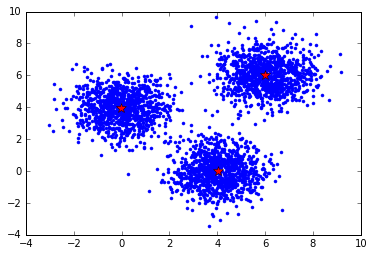

In [5]:
from mr_GMixEmInitialize import MrGMixEmInit
from mr_GMixEmIterate import MrGMixEm
import json
from math import sqrt
import pylab

def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

def dist(x,y):
    #euclidean distance between two lists    
    sum = 0.0
    for i in range(len(x)):
        temp = x[i] - y[i]
        sum += temp * temp
    return sqrt(sum)

#first run the initializer to get starting centroids
filePath = 'data.txt'
mrJob = MrGMixEmInit(args=[filePath, '--file', 'intermediateResults.txt', '--no-strict-protocol'])
with mrJob.make_runner() as runner:
    runner.run()

#pull out the centroid values to compare with values after one iteration
emPath = "intermediateResults.txt"
fileIn = open(emPath)
paramJson = fileIn.read()
fileIn.close()

delta = 10
iter_num = 0
#Begin iteration on change in centroids
while delta > 0.02:
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1
    #parse old centroid values
    oldParam = json.loads(paramJson)
    #run one iteration
    oldMeans = oldParam[1]
    mrJob2 = MrGMixEm(args=[filePath, '--file', 'intermediateResults.txt', '--no-strict-protocol'])
    with mrJob2.make_runner() as runner:
        runner.run()

    #compare new centroids to old ones
    fileIn = open(emPath)
    paramJson = fileIn.read()
    fileIn.close()
    newParam = json.loads(paramJson)

    k_means = len(newParam[1])
    newMeans = newParam[1]

    delta = 0.0
    for i in range(k_means):
        delta += dist(newMeans[i],oldMeans[i])

    print oldMeans
#     plot_iteration(oldMeans)
print "Iteration" + str(iter_num)
print newMeans
plot_iteration(newMeans)